# Aerial Cactus Identification
> To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the VIGIA project, which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. In this competition, you are tasked with creation of an algorithm that can identify a specific type of cactus in aerial imagery.

In [1]:
# Python imports
import os
from datetime import datetime

# Math imports
import numpy as np

# Data and plots imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Machine Learning imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

## Initial investigation

In [2]:
# First we need to assign the paths to variables and load the data
print(os.listdir("../input"))
test_path = '../input/test/test/'
train_path = '../input/train/train/'
train_df = pd.read_csv('../input/train.csv')

['test', 'train', 'train.csv', 'sample_submission.csv']


In [3]:
# Display the head of the dataset
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
# Get the information about entries
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
id            17500 non-null object
has_cactus    17500 non-null int64
dtypes: int64(1), object(1)
memory usage: 273.5+ KB


In [5]:
# Check how many cactus and non-cactus images we have
train_df['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

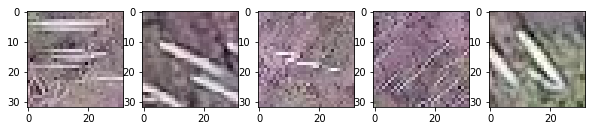

In [6]:
# Create a list of images to display
images = [mpimg.imread(os.path.join(train_path, train_df.iloc[i,0])) for i in range(0,5)]

# Display the images in 5 columns
plt.figure(figsize=(10,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

## Prepare the data

In [7]:
class CactusDataset(Dataset):
    def __init__(self, labels, data_dir, transform=None):
        super().__init__()
        self.labels = labels.values
        self.data_dir = data_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        name, label = self.labels[index]
        img_path = os.path.join(self.data_dir, name)
        img = mpimg.imread(img_path)
        
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [8]:
# Prepare the data
train, valid = train_test_split(train_df, stratify=train_df['has_cactus'], test_size=0.2)

train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
valid_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

train_data = CactusDataset(
    labels=train,
    data_dir=train_path,
    transform=train_tf,
)
valid_data = CactusDataset(
    labels=valid,
    data_dir=train_path,
    transform=valid_tf,
)

## Network

In [9]:
# Create the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.output = nn.Linear(512, 2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return x

## Training

In [10]:
# Hyper parameters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_epochs = 20
n_classes = 2
batch_size = 50
learning_rate = 0.001

In [11]:
# Define loss and optimizer
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Create data loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False)

In [13]:
steps = len(train_loader)
results = []

for epoch in range(n_epochs):
    t_start = datetime.now()
    model.train()
    epoch_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Pass loss to outer loop
        epoch_loss += loss.item()
        
    epoch_loss = epoch_loss / len(train_loader)
    t_elapsed = datetime.now() - t_start
    
    # Model evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():        
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # Calculate accuracy
    epoch_acc = correct / total
    
    # Save results for display
    results.append({'Epoch': epoch+1, 'Loss': epoch_loss, 'Accuracy': epoch_acc})
        
    # Print out epoch data
    print ('Epoch [{:0>2d}/{}], Loss: {:.4f}, Accuracy: {:.4f}, Epoch Time: {}'.format(
        epoch+1, n_epochs, epoch_loss, epoch_acc, t_elapsed,
    ))

Epoch [01/20], Loss: 0.2651, Accuracy: 0.9417, Epoch Time: 0:00:35.534621
Epoch [02/20], Loss: 0.1281, Accuracy: 0.9697, Epoch Time: 0:00:13.889656
Epoch [03/20], Loss: 0.0898, Accuracy: 0.9700, Epoch Time: 0:00:14.341470
Epoch [04/20], Loss: 0.0798, Accuracy: 0.9811, Epoch Time: 0:00:16.945661
Epoch [05/20], Loss: 0.0559, Accuracy: 0.9649, Epoch Time: 0:00:13.536862
Epoch [06/20], Loss: 0.0460, Accuracy: 0.9823, Epoch Time: 0:00:13.163445
Epoch [07/20], Loss: 0.0320, Accuracy: 0.9860, Epoch Time: 0:00:12.384100
Epoch [08/20], Loss: 0.0245, Accuracy: 0.9894, Epoch Time: 0:00:12.185124
Epoch [09/20], Loss: 0.0169, Accuracy: 0.9923, Epoch Time: 0:00:12.418274
Epoch [10/20], Loss: 0.0152, Accuracy: 0.9943, Epoch Time: 0:00:12.398733
Epoch [11/20], Loss: 0.0117, Accuracy: 0.9934, Epoch Time: 0:00:12.236508
Epoch [12/20], Loss: 0.0100, Accuracy: 0.9929, Epoch Time: 0:00:12.928314
Epoch [13/20], Loss: 0.0088, Accuracy: 0.9914, Epoch Time: 0:00:12.672373
Epoch [14/20], Loss: 0.0112, Accuracy:

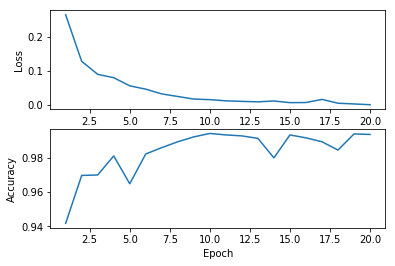

In [14]:
# Store validation results in a DataFrame
results_df = pd.DataFrame(results)
results_df.set_index('Epoch', inplace=True)
results_df.head()

# Display validation results on graph
fig, ax =plt.subplots(2,1)
sns.lineplot(data=results_df, x=results_df.index, y='Loss', ax=ax[0])
sns.lineplot(data=results_df, x=results_df.index, y='Accuracy', ax=ax[1])
fig.show()

## Submission

In [15]:
# Prepare result data
result_df = pd.read_csv('../input/sample_submission.csv')
test_data = CactusDataset(
    labels=result_df,
    data_dir=test_path,
    transform=valid_tf
)
test_loader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False
)

In [16]:
# Create a submission file for test data
model.eval()
predictions = []
for batch_i, (data, target) in enumerate(test_loader):
    data = data.to(device)
    target = target.to(device)
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        predictions.append(i)

result_df['has_cactus'] = predictions
result_df.to_csv('submission.csv', index=False)